# Flower Recognition CNN Keras

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!unzip -qq "/content/gdrive/MyDrive/Ybigta/CNN/과제/flower.zip"

In [3]:
import os
print(os.listdir('/content/flowers'))

['rose', 'dandelion', 'tulip', 'daisy', 'sunflower']


<a id="content1"></a>
## 1 ) Importing Various Modules.

In [4]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

# specifically for cnn
from tensorflow.keras.layers import Dropout, Flatten,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

<a id="content2"></a>
## 2 ) Preparing the Data

## 2.1) Making the functions to get the training and validation set from the Images

In [6]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='/content/flowers/daisy'
FLOWER_SUNFLOWER_DIR='/content/flowers/sunflower'
FLOWER_TULIP_DIR='/content/flowers/tulip'
FLOWER_DANDI_DIR='/content/flowers/dandelion'
FLOWER_ROSE_DIR='/content/flowers/rose'


In [7]:
def assign_label(img,flower_type):
    return flower_type

In [8]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [9]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:01<00:00, 400.01it/s]

764


In [10]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:02<00:00, 329.72it/s]

1497


In [11]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:02<00:00, 365.82it/s]

2481


In [12]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1052/1052 [00:02<00:00, 374.30it/s]

3533


In [13]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:01<00:00, 403.36it/s]

4317


## 2.2 ) Visualizing some Random Images

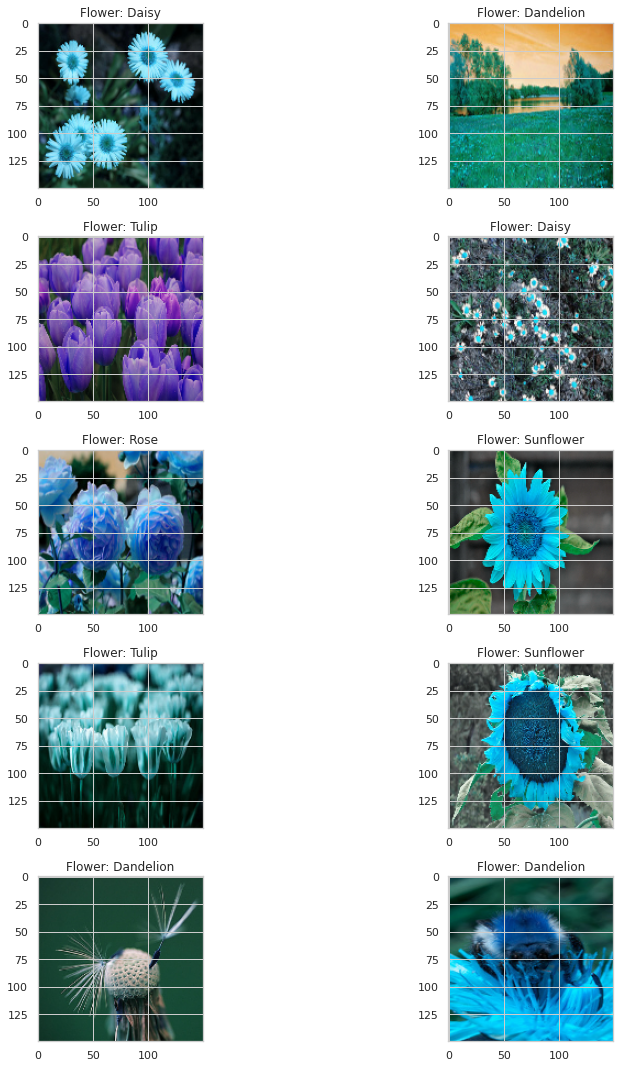

In [14]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()
        

## 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [15]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

## 2.4 ) Splitting into Training and Validation Sets

In [16]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

## 2.5 ) Setting the Random Seeds

In [17]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

<a id="content3"></a>
## 3 ) Modelling

## 3.1 ) Building the ConvNet Model

In [18]:
# modelling starts using a CNN.
#Padding은 전부 대중적인, 즉 stride가 1이라면 input과 output 사이즈를 같게 만들어주는 패딩
#커널사이즈도 대중적인 커널사이즈
#은닉층에 주로쓰는 Activation


model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters =96, kernel_size = (3,3), padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3), padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

## 3.2 ) Using a LR Annealer

In [19]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

## 3.3 ) Data Augmentation to prevent Overfitting

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## 3.4 ) Compiling the Keras Model & Summary

In [25]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 96)       0

## 3.5 ) Fitting on the Training set and making predcitons on the Validation set

In [27]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
25/25 [==============================] - 33s 812ms/step - loss: 1.4178 - accuracy: 0.3493 - val_loss: 1.1734 - val_accuracy: 0.4546
Epoch 2/50
25/25 [==============================] - 18s 721ms/step - loss: 1.1894 - accuracy: 0.4960 - val_loss: 1.1253 - val_accuracy: 0.5657
Epoch 3/50
25/25 [==============================] - 18s 720ms/step - loss: 1.0651 - accuracy: 0.5613 - val_loss: 0.9694 - val_accuracy: 0.6250
Epoch 4/50
25/25 [==============================] - 19s 749ms/step - loss: 0.9622 - accuracy: 0.6153 - val_loss: 0.8945 - val_accuracy: 0.6546
Epoch 5/50
25/25 [==============================] - 19s 752ms/step - loss: 0.8844 - accuracy: 0.6594 - val_loss: 0.9158 - val_accuracy: 0.6537
Epoch 6/50
25/25 [==============================] - 20s 819ms/step - loss: 0.8746 - accuracy: 0.6693 - val_loss: 0.8489 - val_accuracy: 0.6722
Epoch 7/50
25/25 [==============================] - 18s 718ms/step - loss: 0.8095 - accuracy: 0.6912 - val_loss: 0.9684 - val_accuracy: 0.6315

<a id="content4"></a>
## 4 ) Evaluating the Model Performance

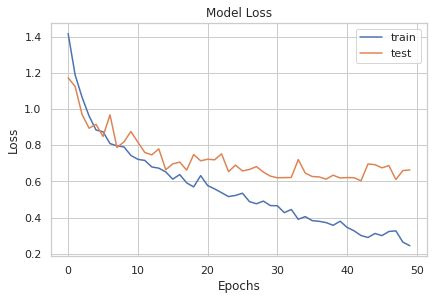

In [28]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

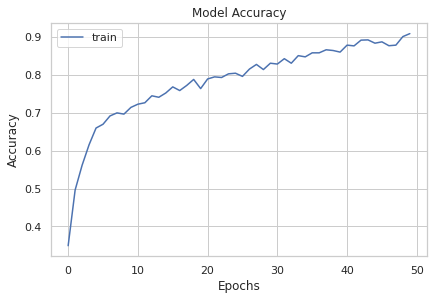

In [29]:
plt.plot(History.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')S
plt.legend(['train', 'test'])
plt.show()

#### CORRECTLY CLASSIFIED FLOWER IMAGES

#  THE END.